# Opening of the data

In [1]:
dataset_path = "datsets/"

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 13:00:48 2018

@author: rniel
"""
import numpy as np

file  = open(dataset_path+"imdb_labelled.txt", "rt")
content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]

x=[]
y=[]
for c in contents:
    temp=c.split("\t")
    x.append(temp[0])
    y.append(int(temp[1]))
    
file  = open(dataset_path+"amazon_cells_labelled.txt", "rt")
content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]


for c in contents:
    temp=c.split("\t")
    x.append(temp[0])
    y.append(int(temp[1]))
    
file  = open(dataset_path+"yelp_labelled.txt", "rt")
content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]


for c in contents:
    temp=c.split("\t")
    x.append(temp[0])
    y.append(int(temp[1]))

In [3]:
file  = open(dataset_path+"book.txt", "rt")
content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]
del contents[-1]

for c in contents:
    temp=c.split("\t")
    x.append(temp[1])
    y.append(int(temp[0]))  

In [2]:
file  = open("Text/rt-polarity-neg.txt", "rt",encoding = "ISO-8859-1")

content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]
del contents[-1]

for i in range(len(contents)):
    x.append(contents[i])
    y.append(0)

file  = open("Text/rt-polarity-pos.txt", "rt",encoding = "ISO-8859-1")
content = file.read()
contents=[]
contents=content.split("\n")
del contents[-1]
del contents[-1]

for i in range(len(contents)):
    x.append(contents[i])
    y.append(1)    


# Pretreatment of the data

In [14]:
def pretreatment(sentences):
    """ This function clean an array of sentence and split them into list of words.
            
        Keyword arguments:
        sentences -- An array of sentences
    """
    for s in sentences:
        s = s.replace(",", " ")
        s = s.replace(".", " ")
        s = s.replace("-", " ")
        s = s.replace("!", " ")
        s = s.replace("?", " ")
        s = s.replace(":", " ")
        s = s.replace("*", " ")
        s = s.replace("\n", " ")


    ret_sentences = []
    for s in sentences:
        ret_sentences.append(s.split(" "))

    for i in range(len(sentences)):
        ret_sentences[i]=[w for w in ret_sentences[i] if w!=""]

    for s in ret_sentences:
        for w in s :
            w=w.lower()
    return ret_sentences


In [5]:
sentences = pretreatment(x)

# Word2Vec part

 ### Training of the Word2Vec model on the data

In [86]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, size=300, min_count=20, workers=4,sorted_vocab=1)
model.train(sentences,total_examples=len(sentences), epochs=10)

(630688, 1126390)

### Loading of the GoogleNews vectors

In [4]:
from gensim.models import KeyedVectors
# load the google word2vec model
filename = 'lib/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True,limit= 500000)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7118192911148071)]


# Transformation of sentences into list of vectors

In [83]:
def vectorization(sentences,word2vec_model,word_length=300,max_len=50,adaptable_len=False):
    """ This function transform an array of list of words (the splitted sentences) into a array of list of vectors 
            representing the words thanks to an already trained word2Vec model
            
        Keyword arguments:
        sentences -- The different sentences you want to vectorize
        word2vec_model -- An already trained gensim Word2Vec model
        word_length -- The number of dimension of the vectors representing the words (default 300) 
        max_len -- The maximum length of a sentence (default 50) 
        adaptable_len -- A boolean allowing to adapt the maximum length to the longest sentence in your dataset
    """
    sentences_v=[]
    unusued_word=[]
    
    import nltk
    from nltk.corpus import stopwords
    sp_words = set(stopwords.words('english'))    
    
    for s in sentences:
        temp=[]
        for w in s :
            if(w not in sp_words):
                try :
                    temp.append(word2vec_model[w])
                except : 
                    unusued_word.append(w)
        sentences_v.append(temp)
        
    if (adaptable_len is True):
        for i in range(len(sentences_v)):
            if(len(sentences_v[i])>max_len):
                max_len=len(sentences_v[i])

    for s in sentences_v:
        sentence_length = len(s)
        if(sentence_length<max_len):    
            for j in range(max_len-sentence_length):
                s.append([0]*word_length)
    return sentences_v,max_len
          

In [8]:
sentences_v = vectorization(sentences,model)

### Saving of the variables for computation time gain

In [9]:
import numpy as np 
np.save("variables/sentences_v_google.npy",sentences_v)
np.save("variables/y.npy",y)

### Loading the variables

In [1]:
import numpy as np 
x_vec_train = np.load("variables/sentences_v_google.npy")
y = np.load("variables/y.npy")

# Splitting of the data into train and test set

In [10]:
from sklearn.model_selection import train_test_split
x_vec_train,x_vec_test,y_vec_train,y_vec_test = train_test_split(sentences_v,y,test_size=0.2,random_state=42)
x_vec_train=np.array(x_vec_train)
x_vec_test=np.array(x_vec_test)
from keras.utils import to_categorical
y_vec_train=to_categorical(y_vec_train)
y_vec_test=to_categorical(y_vec_test)  

Using TensorFlow backend.


# Neural network creation

In [12]:
# Neural Network
def model_creation():
    
    WORD_LENGTH=300
    max_len=50
    
    from keras.models import Sequential
    from keras.layers import Dense, Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM
    from keras.layers import Dropout

    NN = Sequential()

    NN.add(Dense(max_len, activation='relu',input_shape=(max_len,WORD_LENGTH)))
    NN.add(Dropout(0.5))
    
    NN.add(Convolution1D(64,kernel_size=10,activation='relu',border_mode='same',input_shape=(max_len,WORD_LENGTH)))
    NN.add(Dropout(0.5))
    
    NN.add(MaxPooling1D(pool_size=2, strides=None, padding='same'))

    NN.add(LSTM(50))
    NN.add(Dropout(0.5))
        
    NN.add(Dense(50, activation='relu'))
    NN.add(Dropout(0.5))

    NN.add(Dense(25, activation='relu'))
    NN.add(Dropout(0.5))

    NN.add(Dense(2, activation='softmax'))

    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN

# Spliting between test and valid

In [13]:
x_vec_test,x_vec_valid,y_vec_test,y_vec_valid =  train_test_split(x_vec_test,y_vec_test,test_size=0.5,random_state=42)
print("Number of lines in the validation set : "+str(len(x_vec_valid)))
print("Number of lines in the test set: "+str(len(x_vec_test)))

NameError: name 'train_test_split' is not defined

# Training of the model

In [15]:
from keras.models import clone_model

hist=[]
NB_STEPS = 100
NN = model_creation()
for i in range(NB_STEPS):
    print("Etape i :" + str(i))
    #temp_model=clone_model(NN)
    #temp_model.set_weights(NN.get_weights())
    NN.fit(np.array(x_vec_train), np.array(y_vec_train), epochs=1, batch_size=100)
    #hist.append((temp_model,NN.evaluate(x_vec_valid,y_vec_valid)[1]))
    hist.append(NN.evaluate(x_vec_valid,y_vec_valid)[1])

Using TensorFlow backend.


KeyboardInterrupt: 

# Plotting of validation curve

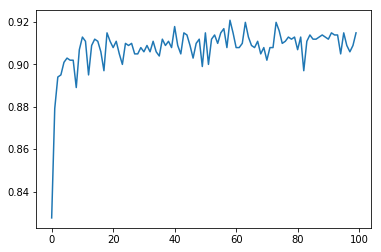

In [48]:
from matplotlib import pyplot as plt

plt.plot(hist)    
plt.show()    

# Training of the model on all the whole dataset

In [58]:
Final = model_creation()
Final.fit(np.array(sentences_v),to_categorical(y),epochs=150,batch_size=100)

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="same")`
  app.launch_new_instance()


Epoch 1/150
10086/10086 [==============================] - 11s 1ms/step - loss: 0.6900 - acc: 0.5428
Epoch 2/150
10086/10086 [==============================] - 6s 559us/step - loss: 0.4709 - acc: 0.7948
Epoch 3/150
10086/10086 [==============================] - 6s 556us/step - loss: 0.2976 - acc: 0.8829
Epoch 4/150
10086/10086 [==============================] - 6s 563us/step - loss: 0.2702 - acc: 0.8899
Epoch 5/150
10086/10086 [==============================] - 6s 560us/step - loss: 0.2393 - acc: 0.9014
Epoch 6/150
10086/10086 [==============================] - 6s 561us/step - loss: 0.2327 - acc: 0.9005
Epoch 7/150
10086/10086 [==============================] - 6s 560us/step - loss: 0.2268 - acc: 0.9039
Epoch 8/150
10086/10086 [==============================] - 6s 558us/step - loss: 0.2177 - acc: 0.9106
Epoch 9/150
10086/10086 [==============================] - 6s 557us/step - loss: 0.2123 - acc: 0.9131
Epoch 10/150
10086/10086 [==============================] - 6s 559us/step - loss: 0

# Cross validation and model comparaison

In [79]:
def time_estimation_cross_val(nb_epochs,nb_s_epoch,nb_split):
    nb_min = (nb_epochs*nb_s_epoch*nb_split*nb_split)/60
    print("The cross_validation will take around : "+str(nb_min)+" mn")
    return nb_min
    
def cross_val(model_function,x_train,y_train,nb_splits,nb_epochs):
    """ This function allows to do a cross validation over a keras model
        Keyword arguments:
        model_function -- A function returning your model
        x_train -- The train data
        y_train -- The train target
        nb_splits -- The number of folds 
        nb_epochs -- The number of epochs you want to train your network with 
                     /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs
    """
    import time    
    start_time = time.time()
    
    indices = np.linspace(0,len(x_train)-1,num=nb_splits+1,dtype=int)
    split_data = []

    # Creation of the splits
    split_data.append((x_train[indices[0]:indices[1]],y_train[indices[0]:indices[1]]))
    for i in range(1,len(indices)-1):
        split_data.append((x_train[indices[i]+1:indices[i+1]],y_train[indices[i]+1:indices[i+1]]))

    # Cross val    
    score = []
    for i in range(nb_splits):
        model = model_function()
        valid = split_data[i]
        for j in range(nb_splits):
            if (j != i):
                model.fit(split_data[j][0],split_data[j][1],epochs=nb_epochs,batch_size=100)
        score.append(model.evaluate(valid[0],valid[1]))
        
    std = np.std([a[1] for a in score])
    mean = np.mean([a[1] for a in score])
    
    print("Accruracy neural network: "+str(mean*100)+"% +- "+str(std*100)+"%")
    print("--- %s minutes elapsed---" % ((time.time() - start_time)/60))

    return model,score,(mean,std)


def multi_cross_val(model_functions,x_train,y_train,nb_splits,nb_epochs):
    """ This function allows to compare different models over a k-fold cross validation
        Keyword arguments:
        model_functions -- A list containing the functions returning the different models you want to test
        x_train -- The train data
        y_train -- The train target
        nb_splits -- The number of folds 
        nb_epochs -- The number of epochs you want to train your network with 
                     /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs
    """
    import time
    
    start_time = time.time()
    
    indices = np.linspace(0,len(x_train)-1,num=nb_splits+1,dtype=int)
    split_data = []

    # Creeation of the splits
    split_data.append((x_train[indices[0]:indices[1]],y_train[indices[0]:indices[1]]))
    for i in range(1,len(indices)-1):
        split_data.append((x_train[indices[i]+1:indices[i+1]],y_train[indices[i]+1:indices[i+1]]))

    # Cross val    
    score = []
    for i in range(nb_splits):
        print("Split no :"+str(i))
        models = [f() for f in model_functions]
        valid = split_data[i]
        for j in range(nb_splits):
            if (j != i):
                for m in models : 
                    m.fit(split_data[j][0],split_data[j][1],epochs=nb_epochs,batch_size=150)                 
        for k in range(len(models)) :
            score.append((k,models[k].evaluate(valid[0],valid[1])))
    std = {}
    mean = {}
    
    for i in range(len(models)):
        tmp = [s for s in score if s[0]==i]
        std[i]=np.std([a[1][1] for a in tmp])
        mean[i]=np.mean([a[1][1] for a in tmp])

    for k in mean.keys():
        print("Accruracy neural network"+str(k) +" : "+str(mean[k]*100)+"% +- "+str(std[k]*100)+"%")
    
    print("--- %s minutes elapsed---" % ((time.time() - start_time)/60))

    return models,score,mean,std

In [72]:
time_estimation_cross_val(80,2,3)

The cross_validation will take around : 24.0 mn


In [78]:
help(multi_cross_val)

Help on function multi_cross_val in module __main__:

multi_cross_val(model_functions, x_train, y_train, nb_splits, nb_epochs)
    This function allows to compare different models over a k-fold cross validation
    Keyword arguments:
    model_functions -- A list containing the functions returning the different models you want to test
    x_train -- The train data
    y_train -- The train target
    nb_splits -- The number of folds 
    nb_epochs -- The number of epochs you want to train your network with 
                 /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs



In [42]:
NN,score, printing = cross_val(model_creation,x_vec_train,y_vec_train,3,80)

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="same")`
  app.launch_new_instance()


Epoch 1/80
2688/2688 [==============================] - 3s 1ms/step - loss: 0.6907 - acc: 0.5387
Epoch 2/80
2688/2688 [==============================] - 1s 553us/step - loss: 0.6896 - acc: 0.5446
Epoch 3/80
2688/2688 [==============================] - 2s 558us/step - loss: 0.6603 - acc: 0.5536
Epoch 4/80
2688/2688 [==============================] - 1s 556us/step - loss: 0.5177 - acc: 0.7582
Epoch 5/80
2688/2688 [==============================] - 1s 549us/step - loss: 0.4184 - acc: 0.8460
Epoch 6/80
2688/2688 [==============================] - 2s 558us/step - loss: 0.3574 - acc: 0.8735
Epoch 7/80
2688/2688 [==============================] - 1s 556us/step - loss: 0.3278 - acc: 0.8854
Epoch 8/80
2688/2688 [==============================] - 2s 558us/step - loss: 0.2962 - acc: 0.8996
Epoch 9/80
2688/2688 [==============================] - 1s 556us/step - loss: 0.2724 - acc: 0.9033
Epoch 10/80
2688/2688 [==============================] - 1s 554us/step - loss: 0.2502 - acc: 0.9022
Epoch 11/80

In [16]:
model_functions = [model_creation,model_creation1]

In [17]:
NNs,test,test1,test2 = multi_cross_val(model_functions,x_vec_train,y_vec_train,3)

Split no :0
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="same")`
  app.launch_new_instance()
/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=4, activation="relu", input_shape=(50, 300), padding="same")`
  from ipykernel import kernelapp as app


Epoch 1/40
799/799 [==============================] - 1s 2ms/step - loss: 0.6929 - acc: 0.5081
Epoch 2/40
799/799 [==============================] - 1s 903us/step - loss: 0.6933 - acc: 0.4981
Epoch 3/40
799/799 [==============================] - 1s 925us/step - loss: 0.6916 - acc: 0.5357
Epoch 4/40
799/799 [==============================] - 1s 952us/step - loss: 0.6936 - acc: 0.5144
Epoch 5/40
799/799 [==============================] - 1s 960us/step - loss: 0.6935 - acc: 0.5019
Epoch 6/40
799/799 [==============================] - 1s 970us/step - loss: 0.6934 - acc: 0.4994
Epoch 7/40
799/799 [==============================] - 1s 996us/step - loss: 0.6907 - acc: 0.5319
Epoch 8/40
799/799 [==============================] - 1s 1ms/step - loss: 0.6952 - acc: 0.4906
Epoch 9/40
799/799 [==============================] - 1s 1ms/step - loss: 0.6940 - acc: 0.5056
Epoch 10/40
799/799 [==============================] - 1s 1ms/step - loss: 0.6928 - acc: 0.5044
Epoch 11/40
799/799 [================

# Plotting of validation curve

In [14]:
from matplotlib import pyplot as plt
acc = []
for i in range(len(hist)):
    acc.append(hist[i][1])

plt.plot(acc)    
plt.show()    


IndexError: invalid index to scalar variable.

# Recuperation of the best model

In [49]:
best = NN

# Evaluation of the model on the test set

In [50]:
best.evaluate(x_vec_test,y_vec_test)


1009/1009 [==============================] - 0s 299us/step


[0.4061938151071075, 0.8860257680872151]

# Saving of the model

In [5]:
def save_model(model,name,path):
    """ This function saves a Keras model.
            
        Keyword arguments:
        model -- The Keras model to be saved
        name -- Name to be given to the Keras model
        path -- Path where to save the Keras model
    """    
    model_json = model.to_json()
    with open(path+name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
        model.save_weights(path+name+".h5")
        print("Saved model to disk")
        
def load_model(name,path):
    """ This function loads a Keras model.
            /!\ You'll need to compile the loaded model.
        Keyword arguments:
        name -- Name of the Keras model
        path -- Path from where to load the Keras model
    """       
    from keras.models import model_from_json
    # load json and create model
    json_file = open(path+name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+name+".h5")
    print("Loaded model from disk")
    return loaded_model


# Utilisation of the model for live prediction

In [6]:
def vote(score):
    """ This function choose return the average of a score array for larger than the maximum size sentences.
            
        Keyword arguments:
        score -- An array containing the score of the different parts of a sentence
    """
    import numpy as np
    neg=[]
    pos=[]
    for s in score :
        neg.append(s[0][0])
        pos.append(s[0][1])
    sup_neg = [n for n in neg if n > 0.5]
    sup_pos = [p for p in pos if p > 0.5]

    return [np.mean(neg),np.mean(pos)]
    
def predict(sentence,word2Vec_model,model,max_len=50,word_length=300):
    """ This function predict if a sentence is positive or negative
            /!\ If the sentence is larger than the max_len, then it's splitted into phrases of max_len length 
            then the average of the predictions of the phrases is made to make the final prediction

        Keyword arguments:
        sentence -- The sentence to make a prediction on
        word2vec_model -- An already trained gensim Word2Vec model
        model -- The keras model to use to make the prediction
        max_len -- The maximum length of a sentence (default 50) 
        word_length -- The number of dimension of the vectors representing the words (default 300) 
    """
    import numpy as np
    sentence = sentence.split(" ")
    good_sentence = []
    unusued_words = []
    for i in range(len(sentence)):
        try :
            sentence[i]=sentence[i].lower()
            good_sentence.append(word2Vec_model.wv[sentence[i]])
        except : 
            unusued_words.append(sentence[i])
    sentence_length = len(good_sentence)
    
    if(sentence_length<max_len):    
        for j in range(max_len-sentence_length):
            good_sentence.append([0]*word_length)     
            
    if (sentence_length > max_len) :
        predictions = []
        ind = 0
        for i in range(int(np.ceil(sentence_length/max_len))):
            sent_tmp = good_sentence[ind:ind+max_len]
            if(len(sent_tmp)<max_len):
                for j in range(max_len-len(sent_tmp)):
                    sent_tmp.append([0]*word_length)    
            sent_tmp = np.array(sent_tmp)        
            sent_tmp = np.reshape(sent_tmp, (1,sent_tmp.shape[0], sent_tmp.shape[1]))
            try :
                predictions.append(model.predict(sent_tmp))
                ind+=max_len                    
            except : 
                print("Erreur au découpage no :"+str(i))
        return vote(predictions)
    
    good_sentence = np.array(good_sentence)        
    good_sentence = np.reshape(good_sentence, (1,good_sentence.shape[0], good_sentence.shape[1]))
    return np.squeeze(model.predict(good_sentence))

# Prediction over a typed sentence

In [11]:
best=NN_loaded
sentence =input()
print(" Négatif        Positif")
print(predict(sentence,model,best))

NameError: name 'NN_loaded' is not defined